# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn.metrics import mean_absolute_error as mae
from sklearn import metrics
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import optuna

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('C:\\Users\\ievge\\Desktop\\jupyter\\data\\unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


##### В данных отсутствуют пропуски, все данные в числовом виде.

## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

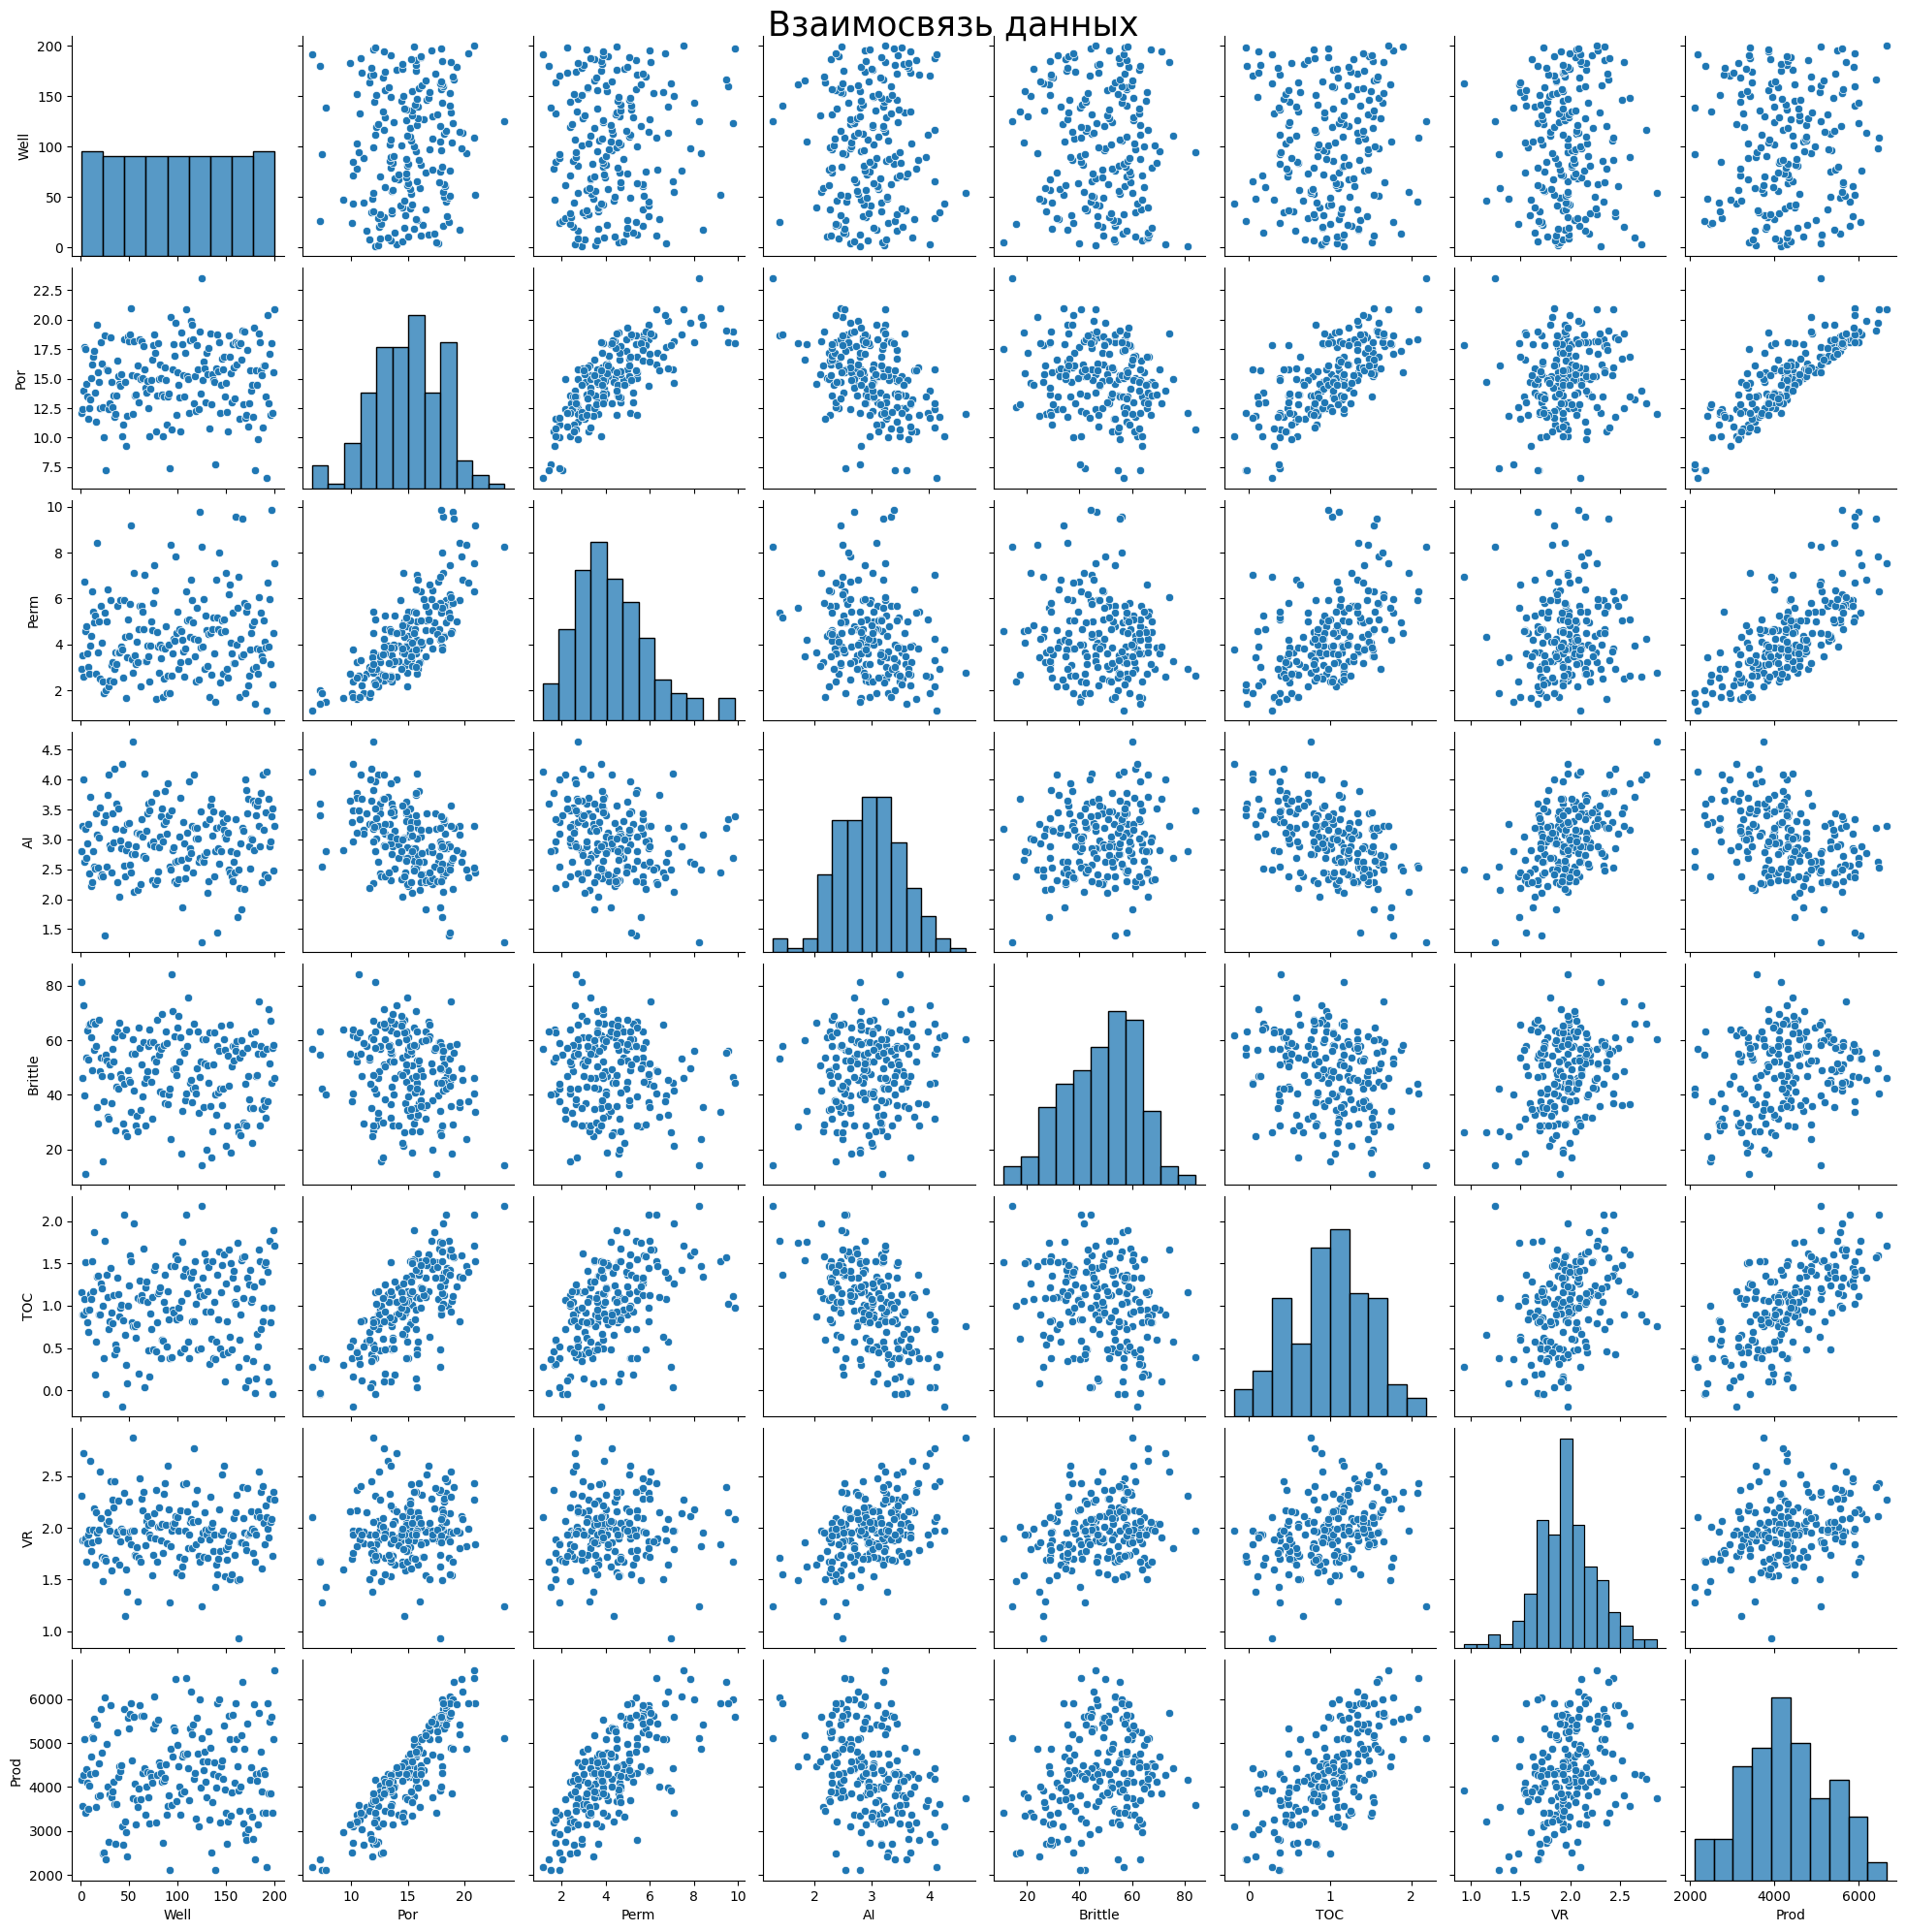

In [4]:
# Построим график для всех переменных.
sns.pairplot(data)
plt.suptitle('Взаимосвязь данных', y=1, size=25);

#### Предварительный вывод:

На предворительном этапе можно заметить, что на добычу газа оказывеют влияние такие факторы как пористость скважины (Por), проницаемость скважины (Perm) и общий органический углерод (TOC). Чем выше эти показатели, тем выше вероятность увеличить объем добычи газа в сутки. Данные показатели имеют пямую связь, с ростом одного показалетя увеличиваются два другие. А такой показатель как акустический импеданс (AI) оказывет обратное влияние на данные три фактора. Его снижение помогает увеличить их рост, и в свою очередь ведет к росту объема добычи газа.
Ниже посмотрим на статистические данные

In [5]:
# Посмотрим на статисчические данные.
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


##### Вывод:
Данные нормально распределены, так как меданное и среднее значечения практически совпадают.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Количество признаков: 8
Ранг корреляционной матрицы: 8
Определитель корреляционной матрицы: 0.0007299388072652082


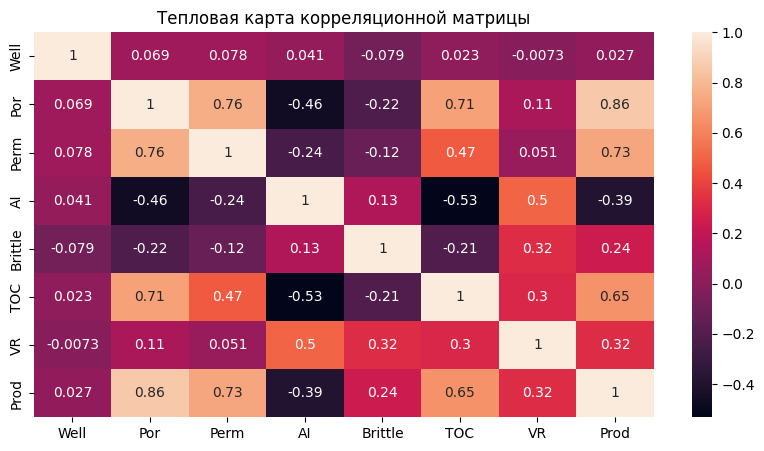

In [6]:
# Построим корреляционную матрицу.
matrix_corr = data.corr()
print(f'Количество признаков: {matrix_corr.shape[1]}')

# Визуализируем корреляционную матрицу через тепловую карту.
plt.figure(figsize = (10, 5))
sns.heatmap(matrix_corr, annot = True).set(title='Тепловая карта корреляционной матрицы');

# Вычислим ранг корреляционной матрицы.
rank = np.linalg.matrix_rank(matrix_corr)
print(f'Ранг корреляционной матрицы: {rank}')

# Вычислим определитель корреляционной матрицы.
determinant = np.linalg.det(matrix_corr)
print(f'Определитель корреляционной матрицы: {determinant}')

## Вывод:

Такие факторы как пористость скважины (Por) и проницаемость скважины (Perm) сильнее всего коррелируют с целевой переменной и имеют сильную связь с ней. Коэффициенты корреляции находятся в диапозоне от 0.7 до 0.9. Также есть фактор идентификатор скважины (Well) коэффициент корреляции которого равен 0.027, что говорит об отсутствии связи с целевой переменной.

Мы получили максимальный ранг матрицы (8), т.к. он совпадает с количеством факторов. А вот полученный определитель близок к нулю. Это связано с наличием мультиколлиниарности в данных. В данном случае мы можем применить модель классической линейной регрессии по методу наименьших квадратов, но основным негативным последствием мультиколлинеарности является снижение точности оценки отдельных коэффициентов. Чтобы увеличить определитель можно попробовать удалить сильно скоррелированные признаки и те которые совсем не приносят никакой информативности.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [7]:
# Создадим матрицу наблюдений `X` и вектор правильных ответов `y`.
X = np.column_stack((np.ones(200), data.drop('Prod', axis=1)))
y = data[['Prod']]

# Вычисляем OLS-оценку для коэффициентов и выводим их значения.
w_coefficient=np.round(np.linalg.inv(X.T@X)@X.T@y).values

# Выведем полученные коэффициенты в виде таблицы.
columns = data.columns[:-1].to_list()
columns.insert(0, 'w0')
display(pd.DataFrame(w_coefficient.T, columns=columns))

,w0,Well,Por,Perm,AI,Brittle,TOC,VR
0,-1232.0,0.0,230.0,116.0,-365.0,25.0,-78.0,785.0


## Вывод:

Полученные коэффициенты показывают как в среднем изменится объем добычи газа, если факторный признак увеличится на одну единицу. Например при увелечить пористость скважины (Por) на 1% объем добычи в среднем увечится на 785 млн. кубических футов. А увеличение общего органического углерода(TOC) на 1% снижает в среднем объем добычи газа на 78 млн. кубических фунтов. Также присутсвует признак индикатор скважины (Well) который не оказывает никакое влияние на целевую переменную. С помощью полученных коэффициентов мы не можем говорить какой фактор оказывает большее влияние на прогноз тк наши данные не стандитизированы, признаки лежат в разных маштабах.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [8]:
# Создадим словарь с параметрами скважины.
parametrs_dict = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }

y_sample_well = [4748.315024]

# Создадим список параметров для прогноза выработки газа скважиной.
parametrs_list = list(parametrs_dict.values())
parametrs_list.insert(0,1)

# Делаем прогноз для выборочной скважины.
prediction = parametrs_list@w_coefficient
print(f'Прогнозный объем выработки газа на выборочной скважине составил: {prediction[0]} млн. кубических футов газа в день.')

# Найдем абсолютную ошибку построенного прогноза.
print('MAE score для выборочной скважины: {:.2f} млн. кубических футов газа в день.'.format(mae(y_sample_well, prediction)))

#Рассчитываем MAPE для выборочной скважины.
print('MAPE score для выборочной скважины: {:.3f} %.'.format(metrics.mean_absolute_percentage_error(y_sample_well, prediction) * 100))
print('_________________________________________________________________________________________________________')

# Делаем прогноз для всех скважин.
prediction_all = X@w_coefficient

# Найдем МАРЕ и коэффициент детерминации построенного прогноза.
print('MAPE score для всех скважин: {:.2f} %.'.format(metrics.mean_absolute_percentage_error(y, prediction_all)*100))
print('R2 score для всех скважин: {:.3f}.'.format(metrics.r2_score(y, prediction_all)))

Прогнозный объем выработки газа на выборочной скважине составил: 4715.26 млн. кубических футов газа в день.
MAE score для выборочной скважины: 33.06 млн. кубических футов газа в день.
MAPE score для выборочной скважины: 0.696 %.
_________________________________________________________________________________________________________
MAPE score для всех скважин: 3.65 %.
R2 score для всех скважин: 0.960.


## Вывод:

На выборочной скважине абсолютная ошибка составила 33.06 млн. кубических футов газа в день. Наша модель ошиблась всего на 0.696 %. Для оценки качества регрессионных моделей и сравнения их между собой выбраны такие метрики как средняя абсолютная ошибка в процентах (так как мы не знаем какое значение целевого показателя является приемлемым) и коэффициент детерминации (с его помощью мы можем понять насколько наша модель лучше, чем простое предсказание средним). На всем наборе данных наша модель в среднем ошибается на 3.65 %, а коэффициент детерминации 0.96, чем ближе он к 1 тем лучше. Из этого следует, что мы получили хорошие результаты, но попробуем их улучшить.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [9]:
# Выведем коэффициенты линейной регрессии.
print('Коэффициенты линейной регрессии:')
display(pd.DataFrame(w_coefficient.T, columns=columns))

# Выведем коэффициенты корреляции.
print('Коэффициенты корреляции:')
matrix_corr.iloc[[-1]].drop('Prod', axis=1)

Коэффициенты линейной регрессии:


,w0,Well,Por,Perm,AI,Brittle,TOC,VR
0,-1232.0,0.0,230.0,116.0,-365.0,25.0,-78.0,785.0


Коэффициенты корреляции:


,Well,Por,Perm,AI,Brittle,TOC,VR
Prod,0.026817,0.86191,0.727426,-0.390835,0.237155,0.654445,0.323182


## Вывод:

Как мы видим, коэффициенты фактора общий органический углерод (TOC), противоречат друг другу. Коэффициент корреляции говорит об прямой зависимости, а коэффициент линейной регрессии - что связь обратная. Так как матрица корреляции плохо обусловлена мы не можем корректно интерпретировать коэффициенты линейной регрессии, поэтому коэффициенты данного фактора противоречат друг другу.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

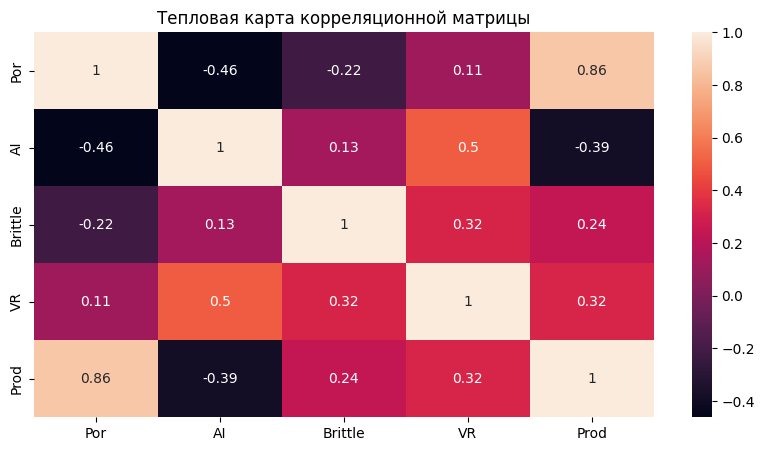

In [10]:
# Удалим сильно коррелированные факторы (коэффициент превышает 0.7) и те, где коэффицент ниже 0.05.
new_data = data.drop(['Well', 'Perm', 'TOC'], axis=1)

# Построим новую матрицу корреляции.
new_matrix_corr = new_data.corr()

# Визуализируем новую корреляционную матрицу через тепловую карту.
plt.figure(figsize = (10, 5))
sns.heatmap(new_matrix_corr, annot = True).set(title='Тепловая карта корреляционной матрицы');

In [11]:
# Создадим матрицу наблюдений `X` и вектор правильных ответов `y`.
X = np.column_stack((np.ones(200), new_data.drop('Prod', axis=1)))
y = new_data[['Prod']]

# Вычисляем OLS-оценку для коэффициентов и выводим их значения.
w_coefficient = np.round(np.linalg.inv(X.T@X)@X.T@y).values

# Выведем полученные коэффициенты в виде таблицы.
columns = new_data.columns[:-1].to_list()
columns.insert(0, 'w0')
display(pd.DataFrame(w_coefficient.T, columns=columns))

# Делаем прогноз.
prediction_all = X@w_coefficient

# Найдем МАРЕ и коэффициент детерминации построенного прогноза.
print('MAPE score: {:.2f} %.'.format(metrics.mean_absolute_percentage_error(y, prediction_all)*100))
print('R2 score: {:.3f}.'.format(metrics.r2_score(y, prediction_all)))

,w0,Por,AI,Brittle,VR
0,-1835.0,293.0,-200.0,28.0,517.0


MAPE score: 4.05 %.
R2 score: 0.945.


## Вывод:

После исключения сильно коллерированных признаков коэффициенты линейной регрессии и коэффициенты корреляции не противоречат друг другу. Увеличение фактора акустический импеданс (AI) на 1 $кг/м^2 10^6$ снижает объем добычи в среднем на 200 млн. кубических футов. А увеличение коэффициента отражения витринита (VR) на 1% в среднем увеличивает объем добычи на 517 млн. кубических футов. Наша модель стала хуже работать, что привело к увеличению средней абсолютной ошибки с 3.65% до 4.05% и коэффициент детерминации снизился с 0.96 до 0.945.*

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [12]:
# Построим модель линейной регрессии.
l_model = LinearRegression(fit_intercept=False)
l_model.fit(X, y)

# Выведем коэффициенты линейной регрссии.
print(f'Коэффициенты линейной регрссии: {np.round(l_model.coef_)}')

# Найдем МАРЕ с помощью кросс-валидации.
cv_mape = cross_validate(l_model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_mape['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_mape['test_score'].mean() * 100))

# Найдем коэффициент детерминации с помощью кросс-валидации.
cv_r2 = cross_validate(l_model, X, y, scoring='r2', cv=5, return_train_score=True)
print('R2 на тренировочных фолдах: {:.2f}'.format(cv_r2['train_score'].mean()))
print('R2 на валидационных фолдах: {:.2f}'.format(cv_r2['test_score'].mean()))

Коэффициенты линейной регрссии: [[-1835.   293.  -200.    28.   517.]]
MAPE на тренировочных фолдах: 4.02 %
MAPE на валидационных фолдах: 4.23 %
R2 на тренировочных фолдах: 0.95
R2 на валидационных фолдах: 0.94


## Вывод:

С помошью модели линейной регрессии из библиотеки scikit-learn (sklearn) мы получили такие же коэффициенты как и вручную. Для нахождения метрик для модели LinearResression мы воспользовались кросс-валидацией и результаты получились практически такие же.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [13]:
# Поведем стандартизацию признаков.
X = new_data.drop('Prod', axis=1)
y = new_data['Prod']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Сгенерируем полиноминальные признаки.
polynom = PolynomialFeatures(degree=3, include_bias=False)
X = polynom.fit_transform(X)

# Выведем количество признаков.
print(f"Количество признаков: {X.shape[1]}")

# Построим модель логистической регрессии.
PL_regression = LinearRegression()

# Найдем МАРЕ с помощью кросс-валидации.
cv_mape = cross_validate(PL_regression, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_mape['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_mape['test_score'].mean() * 100))

# Найдем коэффициент детерминации с помощью кросс-валидации.
cv_r2 = cross_validate(PL_regression, X, y, scoring='r2', cv=5, return_train_score=True)
print('R2 на тренировочных фолдах: {:.2f}'.format(cv_r2['train_score'].mean()))
print('R2 на валидационных фолдах: {:.2f}'.format(cv_r2['test_score'].mean()))

Количество признаков: 34
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %
R2 на тренировочных фолдах: 0.99
R2 на валидационных фолдах: 0.97


## Вывод:

Мы получили 34 полиноминальных признака. Это помогло снизить процент средней ошибки почти в два раза. И увеличить коэффициент детерминации с 0.94 до 0.97. MAPE на тренировочных фолдах: 1.77%, а MAPE на валидационных фолдах: 2.68 %. Но на тестовых данных наша модель справляется хуже, чем на на тестовой. Попробуем воспользоваться регуляризацией и сократить разницу между тренировачными и тестовыми данными.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [14]:
# Подберем наилучший гиперпараметр alpha с помощью optuna.
def optuna_rf(trial, cv=5, X=X, y=y, random_state=42):
    """Функция получения комбинации гиперпараметров."""
    
    # Задаем пространства поиска гиперпараметров.
    alpha = trial.suggest_float('alpha', 0, 5)

    # Создаем модель.
    model = Lasso(alpha=alpha,
                  random_state=42,
                  max_iter=10000)
    
    # Обучаем модель.
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_percentage_error", n_jobs=-1).mean()

    return score


# Создаем объект исследования.
study_lasso = optuna.create_study(study_name="Lasso", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз.
study_lasso.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study_lasso.best_params))

# Создаем модель.
lasso = Lasso(**study_lasso.best_params)
lasso.fit(X, y)

# Найдем МАРЕ с помощью кросс-валидации.
cv_mape = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_mape['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_mape['test_score'].mean() * 100))

# Найдем коэффициент детерминации с помощью кросс-валидации.
cv_r2 = cross_validate(lasso, X, y, scoring='r2', cv=5, return_train_score=True)
print('R2 на тренировочных фолдах: {:.2f}'.format(cv_r2['train_score'].mean()))
print('R2 на валидационных фолдах: {:.2f}'.format(cv_r2['test_score'].mean()))

[I 2023-08-10 21:30:34,879] A new study created in memory with name: Lasso
[I 2023-08-10 21:30:41,767] Trial 0 finished with value: -0.022992452780707003 and parameters: {'alpha': 3.4790495521009994}. Best is trial 0 with value: -0.022992452780707003.
[I 2023-08-10 21:30:41,806] Trial 1 finished with value: -0.023821276641650672 and parameters: {'alpha': 2.1282994077559456}. Best is trial 0 with value: -0.022992452780707003.
[I 2023-08-10 21:30:41,835] Trial 2 finished with value: -0.02291014971116065 and parameters: {'alpha': 3.7144560369709905}. Best is trial 2 with value: -0.02291014971116065.
[I 2023-08-10 21:30:41,859] Trial 3 finished with value: -0.02302724502531755 and parameters: {'alpha': 3.3805477701934237}. Best is trial 2 with value: -0.02291014971116065.
[I 2023-08-10 21:30:41,887] Trial 4 finished with value: -0.025589545707176344 and parameters: {'alpha': 0.4552214670955257}. Best is trial 2 with value: -0.02291014971116065.
[I 2023-08-10 21:30:41,910] Trial 5 finished 

Наилучшие значения гиперпараметров {'alpha': 4.652575635228531}
MAPE на тренировочных фолдах: 1.82 %
MAPE на валидационных фолдах: 2.28 %
R2 на тренировочных фолдах: 0.99
R2 на валидационных фолдах: 0.98


## Вывод:

С помощью регуляризации Lasso нам удалось снизить МАРЕ на валидационных данных с 2.68% до 2.28%. А также удалось увеличить коэффициент детерминации до 0.98%. Мы сократили разницу в метриках. И на тренировочных и на валидационных данных наша модель показывает хорошие результаты.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [15]:
# Подберем наилучший гиперпараметр alpha с помощью optuna.
def optuna_rf(trial, cv=5, X=X, y=y, random_state=42):
    """Функция получения комбинации гиперпараметров."""
    
    # Задаем пространства поиска гиперпараметров.
    alpha = trial.suggest_float('alpha', 0, 50)

    # Создаем модель.
    model = Ridge(alpha=alpha, random_state=42, max_iter=10000)
    
    # Обучаем модель.
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_percentage_error", n_jobs=-1).mean()

    return score


# Создаем объект исследования.
study_ridge = optuna.create_study(study_name="Ridge", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз.
study_ridge.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study_ridge.best_params))

# Создаем модель.
ridge = Ridge(**study_ridge.best_params)
ridge.fit(X, y)

# Найдем МАРЕ с помощью кросс-валидации.
cv_mape = cross_validate(ridge, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_mape['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_mape['test_score'].mean() * 100))

# Найдем коэффициент детерминации с помощью кросс-валидации.
cv_r2 = cross_validate(ridge, X, y, scoring='r2', cv=5, return_train_score=True)
print('R2 на тренировочных фолдах: {:.2f}'.format(cv_r2['train_score'].mean()))
print('R2 на валидационных фолдах: {:.2f}'.format(cv_r2['test_score'].mean()))

[I 2023-08-10 21:30:42,404] A new study created in memory with name: Ridge
[I 2023-08-10 21:30:42,538] Trial 0 finished with value: -0.056007982024527427 and parameters: {'alpha': 32.83924750799655}. Best is trial 0 with value: -0.056007982024527427.
[I 2023-08-10 21:30:42,557] Trial 1 finished with value: -0.05603140539289608 and parameters: {'alpha': 32.881275796484694}. Best is trial 0 with value: -0.056007982024527427.
[I 2023-08-10 21:30:42,574] Trial 2 finished with value: -0.06299182293547524 and parameters: {'alpha': 47.617185525508845}. Best is trial 0 with value: -0.056007982024527427.
[I 2023-08-10 21:30:42,592] Trial 3 finished with value: -0.02712360027067458 and parameters: {'alpha': 0.9416761498052706}. Best is trial 3 with value: -0.02712360027067458.
[I 2023-08-10 21:30:42,611] Trial 4 finished with value: -0.03776664297575701 and parameters: {'alpha': 9.648402397756357}. Best is trial 3 with value: -0.02712360027067458.
[I 2023-08-10 21:30:42,635] Trial 5 finished wit

Наилучшие значения гиперпараметров {'alpha': 0.04167837967961574}
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %
R2 на тренировочных фолдах: 0.99
R2 на валидационных фолдах: 0.97


## Вывод:

С помощью регуляризации Ridge мы получили хуше результаты, чем с помошью регуляризации Lasso. МАРЕ на валидационных данных составила 2.67%. Коэффициент детерминации остался прежним 0.98%. Разница в метриках увеличилась.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [16]:
# Подберем наилучшие гиперпараметры с помощью optuna.
def optuna_rf(trial, cv=5, X=X, y=y, random_state=42):
    """Функция получения комбинации гиперпараметров."""
    
    # Задаем пространства поиска гиперпараметров.
    alpha = trial.suggest_float('alpha', 0, 20)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    # Создаем модель.
    model = ElasticNet(alpha=alpha, 
                       l1_ratio=l1_ratio,
                       random_state=42,
                       max_iter=10000)
    # Обучаем модель.
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_percentage_error", n_jobs=-1).mean()

    return score


# Создаем объект исследования.
study_elasticnet= optuna.create_study(study_name="ElasticNet", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз.
study_elasticnet.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study_elasticnet.best_params))

# Создаем модель.
elastic = ElasticNet(**study_elasticnet.best_params,random_state=42, max_iter=10000)

# Найдем МАРЕ с помощью кросс-валидации.
cv_mape = cross_validate(elastic, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_mape['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_mape['test_score'].mean() * 100))

# Найдем коэффициент детерминации с помощью кросс-валидации.
cv_r2 = cross_validate(elastic, X, y, scoring='r2', cv=5, return_train_score=True)
print('R2 на тренировочных фолдах: {:.2f}'.format(cv_r2['train_score'].mean()))
print('R2 на валидационных фолдах: {:.2f}'.format(cv_r2['test_score'].mean()))

[I 2023-08-10 21:30:43,039] A new study created in memory with name: ElasticNet
[I 2023-08-10 21:30:43,067] Trial 0 finished with value: -0.07314337204367187 and parameters: {'alpha': 0.6130560158355469, 'l1_ratio': 0.21748021078965984}. Best is trial 0 with value: -0.07314337204367187.
[I 2023-08-10 21:30:43,088] Trial 1 finished with value: -0.08693164874491714 and parameters: {'alpha': 1.7533248732187623, 'l1_ratio': 0.4830885739789542}. Best is trial 0 with value: -0.07314337204367187.
[I 2023-08-10 21:30:43,112] Trial 2 finished with value: -0.1312307102963334 and parameters: {'alpha': 16.184834862472204, 'l1_ratio': 0.4683142829450516}. Best is trial 0 with value: -0.07314337204367187.
[I 2023-08-10 21:30:43,134] Trial 3 finished with value: -0.08775187594859281 and parameters: {'alpha': 6.32280935774155, 'l1_ratio': 0.858175600435133}. Best is trial 0 with value: -0.07314337204367187.
[I 2023-08-10 21:30:43,155] Trial 4 finished with value: -0.12144075445158424 and parameters: {

Наилучшие значения гиперпараметров {'alpha': 0.36083165717526633, 'l1_ratio': 0.989293855645566}
MAPE на тренировочных фолдах: 1.79 %
MAPE на валидационных фолдах: 2.61 %
R2 на тренировочных фолдах: 0.99
R2 на валидационных фолдах: 0.98


## Вывод:

МАРЕ на валидационных данных составила 2.65%. Коэффициент детерминации прежним 0.98%. Но с помощью регуляризации Lasso мы получили самые лучшие результаты на валидационных данных, а также наименьшую разницу в метриках.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [17]:
# Создадим словарь с полученными результатами.
results_dict = {
    'Linear_models': ['LinearRegression', 'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet'],
    'Hiperparameter_alpha': ['', '', study_lasso.best_params['alpha'], study_ridge.best_params['alpha'], study_elasticnet.best_params['alpha']],
    'Hiperparameter_l1_ratio': ['', '', '', '', study_elasticnet.best_params['l1_ratio']],
    'Polynomial_features': ['False', 'True', 'True', 'True', 'True'],
    'MAPE_train': [4.02, 1.77, 1.82, 1.77, 1.78],
    'MAPE_test': [4.23, 2.68, 2.28, 2.67, 2.65],
    'R2_train': [0.95, 0.99, 0.99, 0.99, 0.99],
    'R2_test': [0.94, 0.97, 0.98, 0.98, 0.98]
}

# Создадим датафрейм с полученными результатами.
results_df = pd.DataFrame(results_dict)

# Выводим датафрейм.
display(results_df)

,Linear_models,Hiperparameter_alpha,Hiperparameter_l1_ratio,Polynomial_features,MAPE_train,MAPE_test,R2_train,R2_test
0,LinearRegression,,,False,4.02,4.23,0.95,0.94
1,LinearRegression,,,True,1.77,2.68,0.99,0.97
2,Lasso,4.652576,,True,1.82,2.28,0.99,0.98
3,Ridge,0.041678,,True,1.77,2.67,0.99,0.98
4,ElasticNet,0.360832,0.989294,True,1.78,2.65,0.99,0.98


## Вывод:

Таким образом мы видим, что с использованием полиномиальных факторов и линейной регрессии с регуляризации Lasso, а также с подобранным гиперпараметром alpha равным 4.638307 мы получили самые лучшие результаты на валидационных данных, а также наименьшую разницу в метриках. Наша модель ошибается в среднем на 2.28%, а доля разнообрация, которую улавливает наша модель, составляет 0.98.